In [1]:
#====================================================================
# This code performs EOF analysis on the near-field tornadic and
# far-field tornadic V2 ensembles to analyze modes of variability.
# This script focuses on the near-field vs. the far-field ensemble.
#====================================================================

In [2]:
#====================================================================
# Import libraries.
#====================================================================
import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netCDF4 import Dataset,num2date
from mpl_toolkits.basemap import Basemap,cm
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
from scipy import stats
from pylab import rcParams
import matplotlib.colors as colors

warnings.simplefilter('ignore')

In [3]:
#====================================================================
# Functions.
#====================================================================
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
#====================================================================
# Read in near-field data.
#====================================================================

#--------------------------------------------------------------------
# First, enter locations of tornadogenesis/failure for all
# near field members below.
#--------------------------------------------------------------------
x_loc_nf_tor_final = [443,436,445,441,441,440,435,442,435,443,444,438,445,449,441]
y_loc_nf_tor_final = [442,442,436,442,440,433,431,439,438,430,441,440,438,443,439]

#--------------------------------------------------------------------
# Now read in the data
#--------------------------------------------------------------------
num_ens = 15
num_x = 864
num_y = 864

#--------------------------------------------------------------------
# Calculate starting/ending indices to read in data.
#--------------------------------------------------------------------
zlevel     = 0          # model level to extract variables (lowest model level... 10 m AGL)
dist_total = 20000      # length/width of box around vortex to retrieve reflectivity to composite (m)
spacing    = 125        # horizontal grid spacing of model (m)
    
dist = dist_total / spacing / 2

dist2 = int(dist*2) # used for indexing the 'refl' array below

refl_nf = np.ones((num_ens,dist2,dist2))*np.nan
w_nf    = np.ones((num_ens,dist2,dist2))*np.nan
zvort_nf = np.ones((num_ens,dist2,dist2))*np.nan
thetarho_nf = np.ones((num_ens,dist2,dist2))*np.nan
u_sr_nf = np.ones((num_ens,dist2,dist2))*np.nan
v_sr_nf = np.ones((num_ens,dist2,dist2))*np.nan

sims_nf   = ['R2','R20','R21','R22','R23','R24','R25','R26','R27','R28','R29','R30','R31','R32','R33']
time_nf_final = [53,55,55,55,53,49,53,52,56,56,55,52,53,55,52]

for i in np.arange(0,num_ens):
    
    t = time_nf_final[i]
    
    if t < 100:
        filepath = '/Volumes/Promise_Pegasus_70TB/v2_comp_tor/' + sims_nf[i] + '_rerun/cm1out_0000' + str(t) + '.nc'
        data = Dataset(filepath)
    else:
        filepath = '/Volumes/Promise_Pegasus_70TB/v2_comp_tor/' + sims_nf[i] + '_rerun/cm1out_000' + str(t) + '.nc'
        data = Dataset(filepath)
    
    start_y = int(y_loc_nf_tor_final[i] - dist)
    end_y   = int(y_loc_nf_tor_final[i] + dist)
    
    start_x = int(x_loc_nf_tor_final[i] - dist)
    end_x   = int(x_loc_nf_tor_final[i] + dist)   
    
    refl_nf[i,:,:] = data['dbz'][0,zlevel,start_y:end_y,start_x:end_x]
    w_nf[i,:,:]    = data['winterp'][0,49,start_y:end_y,start_x:end_x]    # 49th index is just about 1 km AGL
    zvort_nf[i,:,:] = data['zvort'][0,zlevel,start_y:end_y,start_x:end_x]
    
    u = data['uinterp'][0,zlevel,start_y:end_y,start_x:end_x]             # u component of the wind
    v = data['vinterp'][0,zlevel,start_y:end_y,start_x:end_x]             # v component of the wind
    
    u_sr_nf[i,:,:] = u - 1.59         # umove/vmove already subtracted, this subtraction is additional storm motion on top of that
    v_sr_nf[i,:,:] = v
    
    theta = data['th'][0,zlevel,start_y:end_y,start_x:end_x]        # potential temperature
    qv = data['qv'][0,zlevel,start_y:end_y,start_x:end_x]           # water vapor mixing ratio
    qc = data['qc'][0,zlevel,start_y:end_y,start_x:end_x]           # cloud mixing ratio
    qr = data['qr'][0,zlevel,start_y:end_y,start_x:end_x]           # rain mixing ratio
    qi = data['qi'][0,zlevel,start_y:end_y,start_x:end_x]           # ice mixing ratio
    qs = data['qs'][0,zlevel,start_y:end_y,start_x:end_x]           # snow mixing ratio
    qg = data['qg'][0,zlevel,start_y:end_y,start_x:end_x]           # graupel mixing ratio
    qhl = data['qhl'][0,zlevel,start_y:end_y,start_x:end_x]         # something mixing ratio
    
    #------------------------------------------------------
    # Calculate density potential temperature...
    #------------------------------------------------------
    q_total_hyd = qc + qr + qi + qs + qg + qhl        # total hydrometeor mixing ratio (except for water vapor)
    
    Rd = 287.04    
    Rv = 461.51
    
    epsilon = Rd/Rv
    
    thetarho = theta * (1 + (qv/epsilon)) / (1 + (qv + q_total_hyd))
    
    thetarho_nf[i,:,:] = thetarho - 309.2
    
# #---------------------------------------------------------
# # Calculate composites for this specific time.
# #---------------------------------------------------------
# nontor_members = [8]
# tor_members    = [0,1,2,3,4,5,6,7,9,10,11,12,13,14]

# nontor_refl_comp = np.mean(refl[nontor_members,:,:],axis=0)
# tor_refl_comp    = np.mean(refl[tor_members,:,:],axis=0)

# nontor_w_comp = np.mean(w[nontor_members,:,:],axis=0)
# tor_w_comp    = np.mean(w[tor_members,:,:],axis=0)







In [5]:
#====================================================================
# Read in far-field data.
#====================================================================

#--------------------------------------------------------------------
# First, enter locations of tornadogenesis/failure for all
# far field members below.
#--------------------------------------------------------------------
# -- locations of tornadogenesis/failure in FAR-FIELD experiments --
x_loc_ff_tor_final = [465,460,461,513,477,508,477,468,449,474,461,470,515,450,476]
y_loc_ff_tor_final = [426,427,423,404,427,420,434,431,441,424,425,435,411,416,428]
#                     R3.  4.  5.  6.  7.  8.  9.  10  11. 12. 13. 14. 15. 16. 17

#--------------------------------------------------------------------
# Now read in the data
#--------------------------------------------------------------------
num_ens = 15
num_x = 864
num_y = 864

#--------------------------------------------------------------------
# Calculate starting/ending indices to read in data.
#--------------------------------------------------------------------
zlevel     = 0          # model level to extract variables (lowest model level... 10 m AGL)
dist_total = 20000      # length/width of box around vortex to retrieve reflectivity to composite (m)
spacing    = 125        # horizontal grid spacing of model (m)
    
dist = dist_total / spacing / 2

dist2 = int(dist*2) # used for indexing the 'refl' array below

refl_ff = np.ones((num_ens,dist2,dist2))*np.nan
w_ff    = np.ones((num_ens,dist2,dist2))*np.nan
zvort_ff = np.ones((num_ens,dist2,dist2))*np.nan
thetarho_ff = np.ones((num_ens,dist2,dist2))*np.nan
u_sr_ff = np.ones((num_ens,dist2,dist2))*np.nan
v_sr_ff = np.ones((num_ens,dist2,dist2))*np.nan

sims_ff   = ['R3','R4','R5','R6','R7','R8','R9','R10','R11','R12','R13','R14','R15','R16','R17']
time_ff_final = [74,60,79,111,69,99,72,62,83,50,83,61,98,76,76]

for i in np.arange(0,num_ens):
    
    t = time_ff_final[i]
    
    if t < 100:
        filepath = '/Volumes/Promise_Pegasus_70TB/v2_comp_tor/' + sims_ff[i] + '_rerun/cm1out_0000' + str(t) + '.nc'
    else:
        filepath = '/Volumes/Promise_Pegasus_70TB/v2_comp_tor/' + sims_ff[i] + '_rerun/cm1out_000' + str(t) + '.nc'
        
    data = Dataset(filepath)
    
    start_y = int(y_loc_ff_tor_final[i] - dist)
    end_y   = int(y_loc_ff_tor_final[i] + dist)
    
    start_x = int(x_loc_ff_tor_final[i] - dist)
    end_x   = int(x_loc_ff_tor_final[i] + dist)   
    
    refl_ff[i,:,:] = data['dbz'][0,zlevel,start_y:end_y,start_x:end_x]
    w_ff[i,:,:]    = data['winterp'][0,49,start_y:end_y,start_x:end_x]    # 49th index is just about 1 km AGL
    zvort_ff[i,:,:] = data['zvort'][0,zlevel,start_y:end_y,start_x:end_x]
    
    u = data['uinterp'][0,zlevel,start_y:end_y,start_x:end_x]             # u component of the wind
    v = data['vinterp'][0,zlevel,start_y:end_y,start_x:end_x]             # v component of the wind
    
    u_sr_ff[i,:,:] = u - 1.59         # umove/vmove already subtracted, this subtraction is additional storm motion on top of that
    v_sr_ff[i,:,:] = v
    
    theta = data['th'][0,zlevel,start_y:end_y,start_x:end_x]        # potential temperature
    qv = data['qv'][0,zlevel,start_y:end_y,start_x:end_x]           # water vapor mixing ratio
    qc = data['qc'][0,zlevel,start_y:end_y,start_x:end_x]           # cloud mixing ratio
    qr = data['qr'][0,zlevel,start_y:end_y,start_x:end_x]           # rain mixing ratio
    qi = data['qi'][0,zlevel,start_y:end_y,start_x:end_x]           # ice mixing ratio
    qs = data['qs'][0,zlevel,start_y:end_y,start_x:end_x]           # snow mixing ratio
    qg = data['qg'][0,zlevel,start_y:end_y,start_x:end_x]           # graupel mixing ratio
    qhl = data['qhl'][0,zlevel,start_y:end_y,start_x:end_x]         # something mixing ratio
    
    #------------------------------------------------------
    # Calculate density potential temperature...
    #------------------------------------------------------
    q_total_hyd = qc + qr + qi + qs + qg + qhl        # total hydrometeor mixing ratio (except for water vapor)
    
    Rd = 287.04    
    Rv = 461.51
    
    epsilon = Rd/Rv
    
    thetarho = theta * (1 + (qv/epsilon)) / (1 + (qv + q_total_hyd))
    
    thetarho_ff[i,:,:] = thetarho - 309.4
    
# #---------------------------------------------------------
# # Calculate composites for this specific time.
# #---------------------------------------------------------
# nontor_members = [8]
# tor_members    = [0,1,2,3,4,5,6,7,9,10,11,12,13,14]

# nontor_refl_comp = np.mean(refl[nontor_members,:,:],axis=0)
# tor_refl_comp    = np.mean(refl[tor_members,:,:],axis=0)

# nontor_w_comp = np.mean(w[nontor_members,:,:],axis=0)
# tor_w_comp    = np.mean(w[tor_members,:,:],axis=0)







In [7]:
#====================================================================
# Conduct EOF analysis.
#====================================================================

#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# Calculate the time-composite for each array.
#--------------------------------------------------------------------
refl_nf_comp = np.mean(refl_nf,axis=0)
w_nf_comp = np.mean(w_nf,axis=0)

refl_ff_comp = np.mean(refl_ff,axis=0)
w_ff_comp = np.mean(w_ff,axis=0)

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field ---
A = w_nf_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)



U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [84.30355613  2.81425531  1.98612336  1.96343974  1.51510364  1.289926
  1.04039883  0.84998692  0.78150648  0.76713214  0.65730077  0.58901372
  0.52493365  0.5004414   0.41688192]


Text(0, 0.5, 'Eigenvalue')

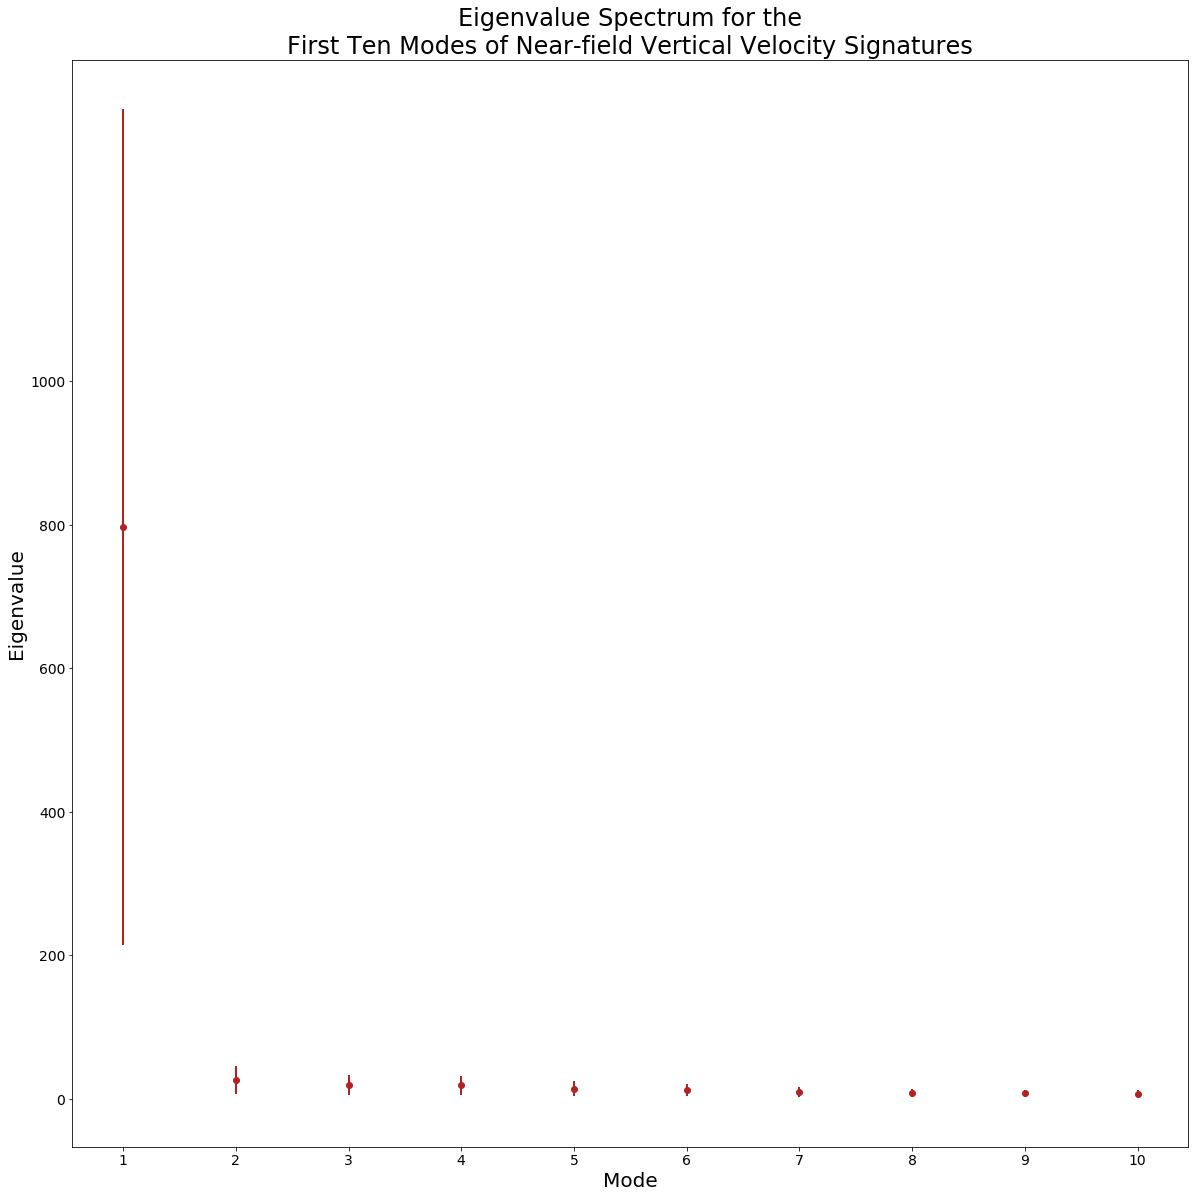

In [8]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title('Eigenvalue Spectrum for the\nFirst Ten Modes of Near-field Vertical Velocity Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues],yerr=deltaLambda[:numValues],color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,1200,200),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel('Eigenvalue',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/NF_w_eigs',dpi=300)

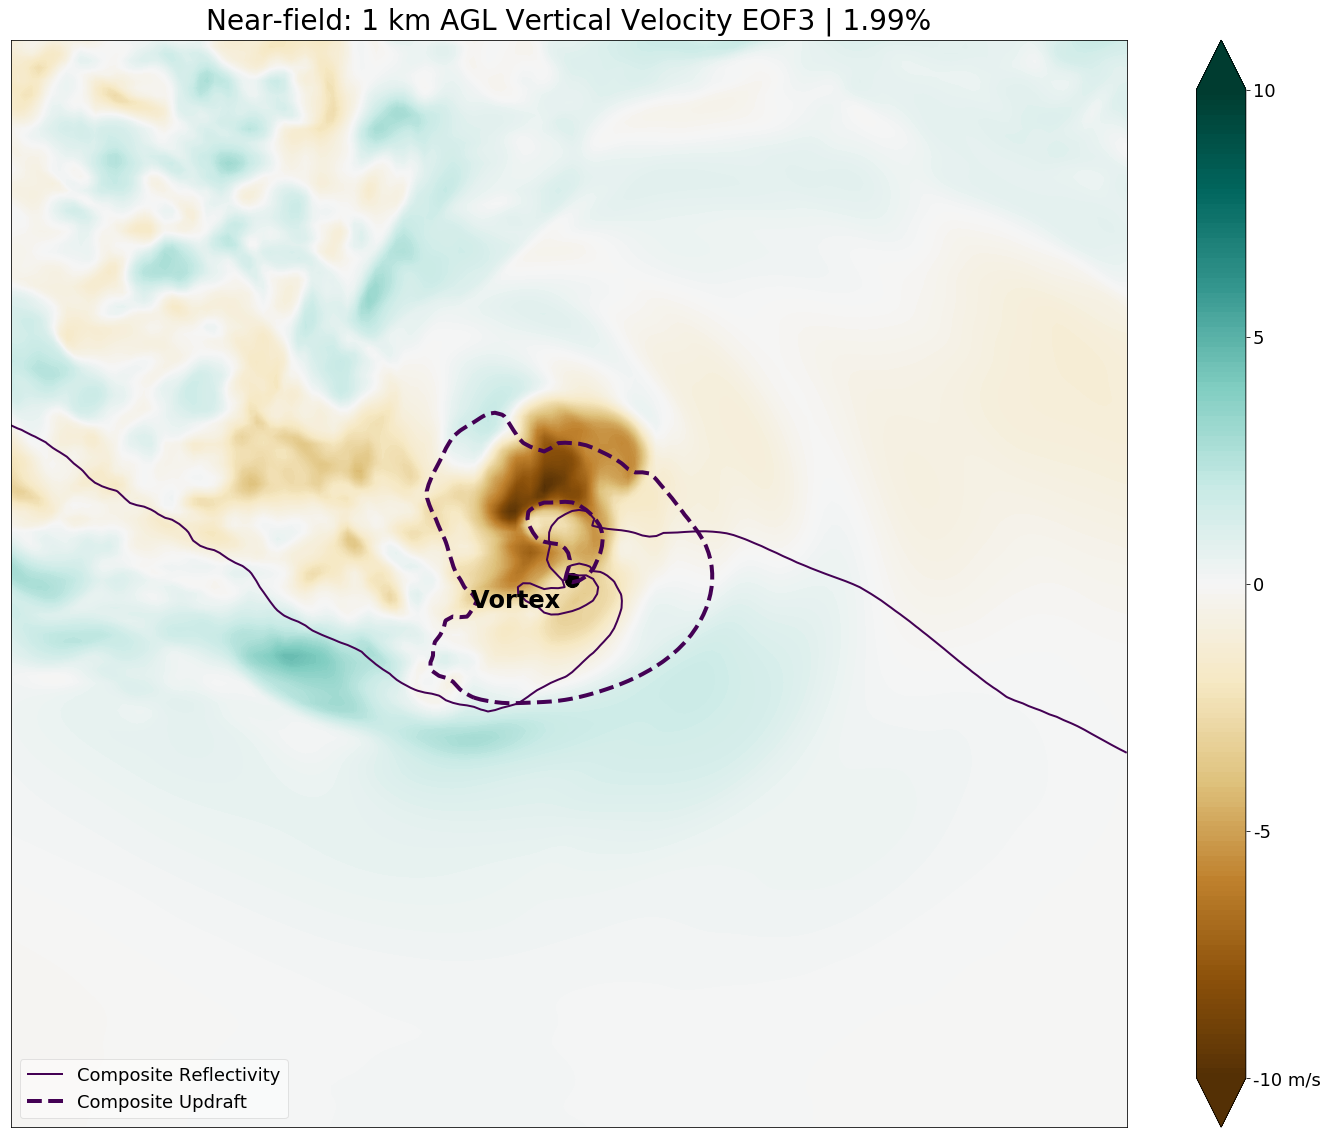

In [9]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 2

cmap1 = plt.cm.get_cmap('BrBG')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_nf_comp,'k',linewidths=2,levels=[10])
h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
w = plt.contour(x,y,w_nf_comp,'k',linestyles='dashed',linewidths=4,levels=[20],label='Composite Updraft')
h2,_ = w.legend_elements()

# --- EOF ---
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=np.arange(-10,10.1,0.1),extend='both')

plt.xticks([],[])
plt.yticks([],[])

cbar = plt.colorbar(ticks=np.arange(-10,15,5))
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-10 m/s','-5','0','5','10'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist-8,dist-4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = 'Near-field: 1 km AGL Vertical Velocity EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
           loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/NF_w_EOF'+str(mode+1),dpi=300)




In [10]:
#====================================================================
# Conduct EOF analysis.
#====================================================================

#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- Second, far-field ---
A = w_ff_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)




U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [71.22153375  9.0356877   3.15458203  2.66174543  2.14145536  2.01743319
  1.80623978  1.44901141  1.21101108  1.0674493   1.03810963  0.96163856
  0.85539253  0.77057308  0.60813718]


Text(0, 0.5, 'Eigenvalue')

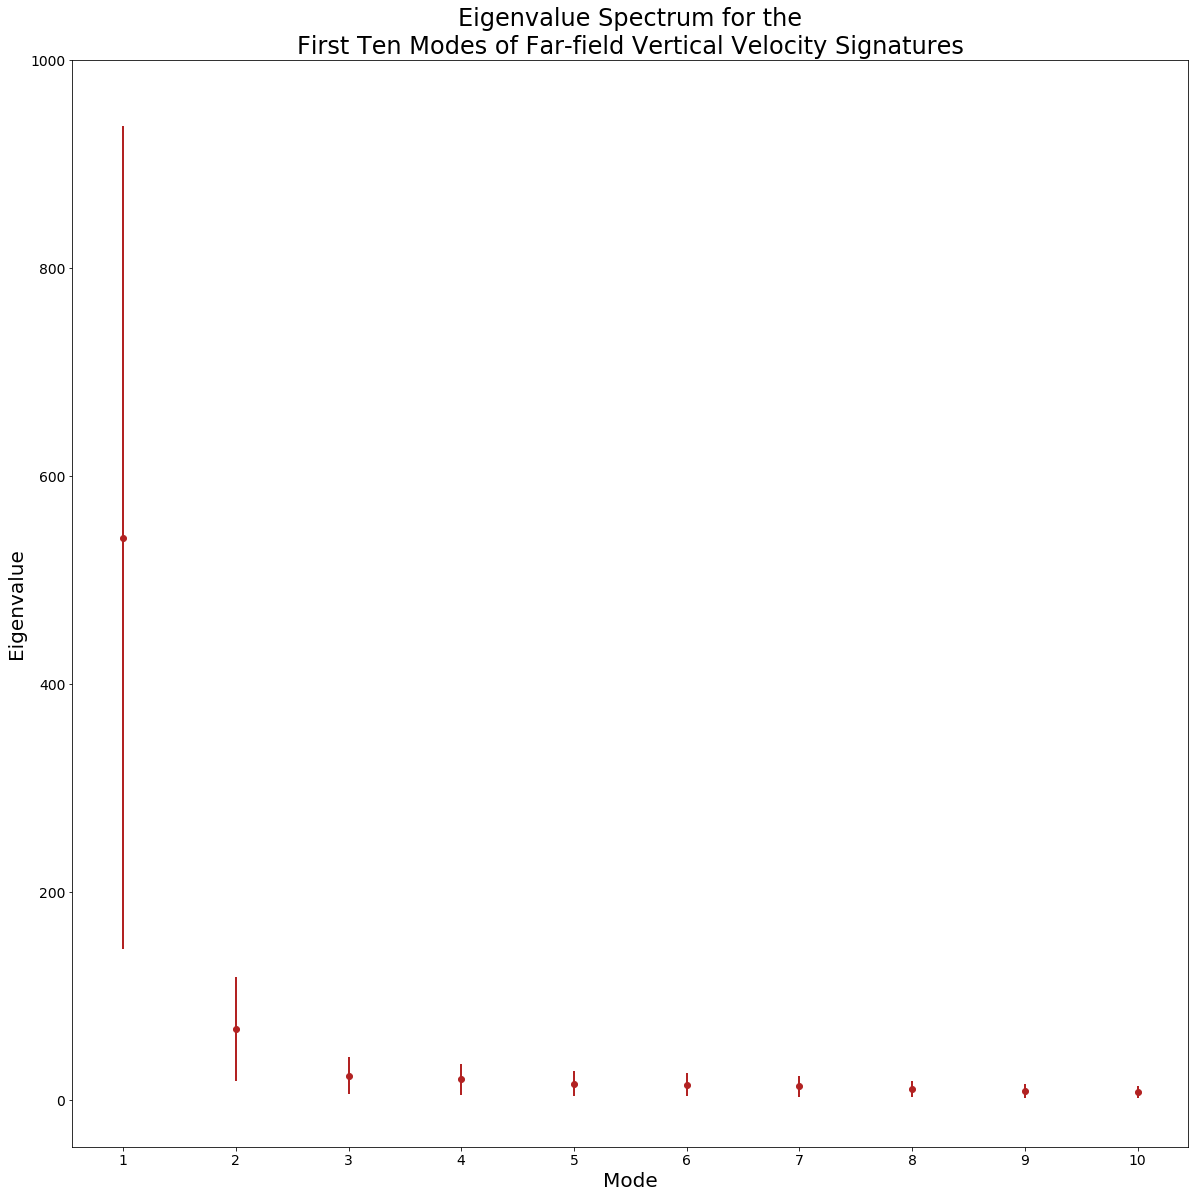

In [11]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title('Eigenvalue Spectrum for the\nFirst Ten Modes of Far-field Vertical Velocity Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues],yerr=deltaLambda[:numValues],color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,1200,200),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel('Eigenvalue',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/FF_w_eigs',dpi=300)

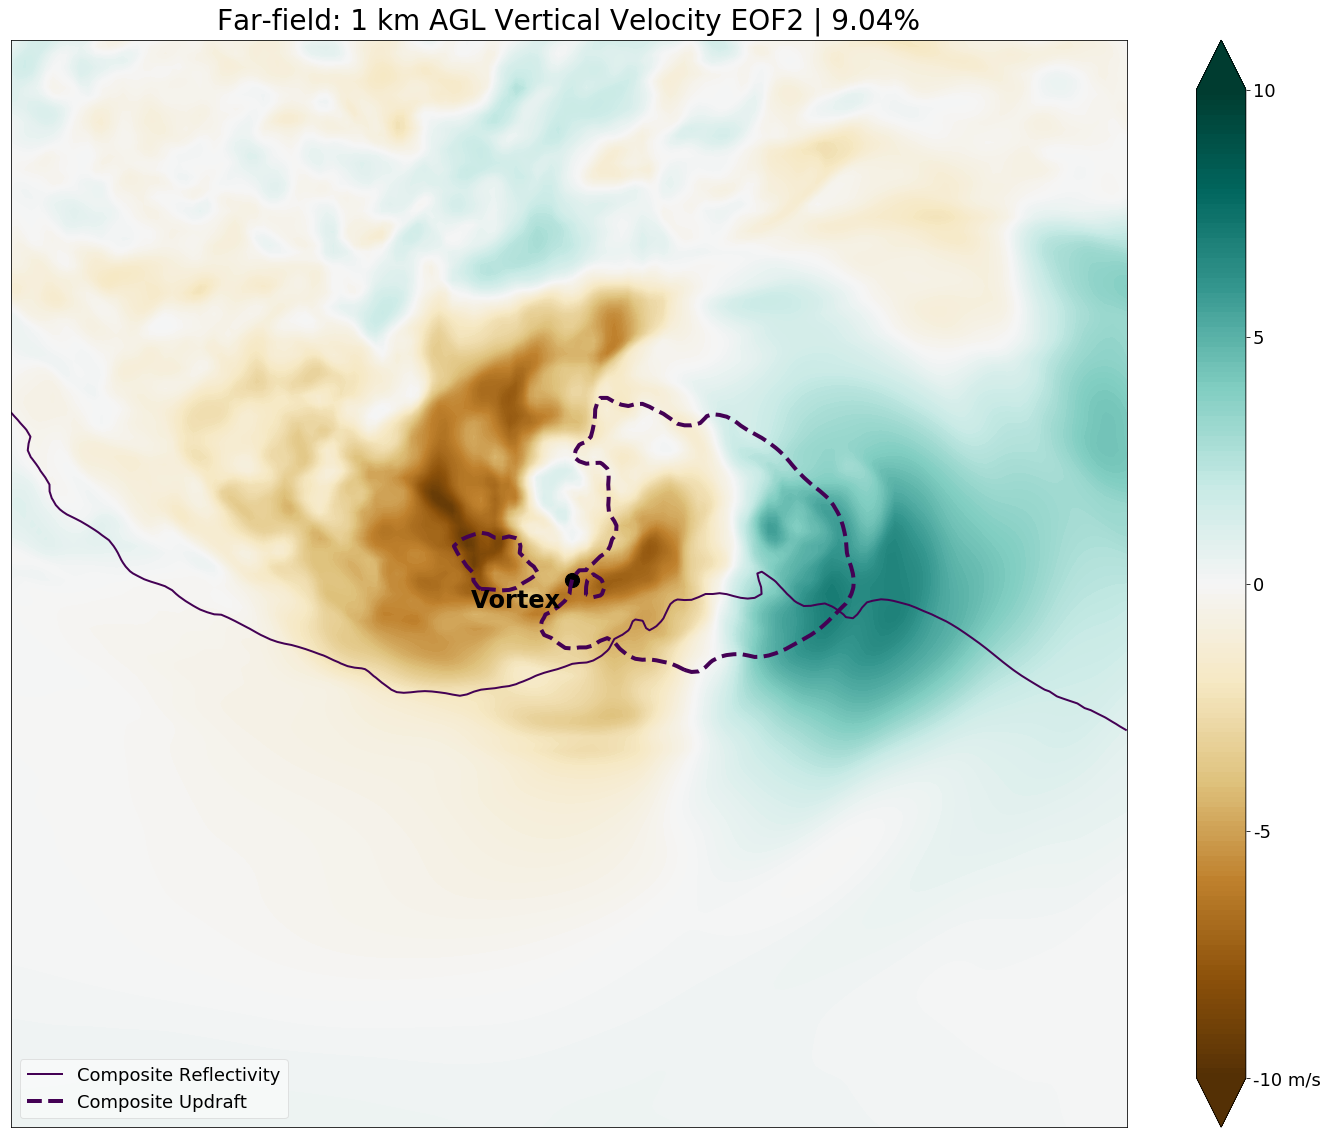

In [12]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 1

cmap1 = plt.cm.get_cmap('BrBG')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_ff_comp,'k',linewidths=2,levels=[10])
h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
h2,_ = w.legend_elements()

# --- EOF ---
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=np.arange(-10,10.1,0.1),extend='both')

plt.xticks([],[])
plt.yticks([],[])

cbar = plt.colorbar(ticks=np.arange(-10,15,5))
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-10 m/s','-5','0','5','10'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist-8,dist-4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = 'Far-field: 1 km AGL Vertical Velocity EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
           loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/FF_w_EOF'+str(mode+1),dpi=300)





In [9]:
#====================================================================
# Conduct EOF analysis (10 m AGL vertical vorticity.)
#====================================================================

#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# Calculate the time-composite for each array.
#--------------------------------------------------------------------
refl_nf_comp = np.mean(refl_nf,axis=0)
w_nf_comp = np.mean(w_nf,axis=0)

refl_ff_comp = np.mean(refl_ff,axis=0)
w_ff_comp = np.mean(w_ff,axis=0)



#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field ---
A = zvort_nf_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)





U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [62.43527601  5.2467485   4.01887088  3.9704377   3.02943077  2.85479192
  2.65088737  2.35084642  2.31398314  2.09999015  2.016277    1.97245308
  1.82323278  1.79881056  1.41796372]


Text(0, 0.5, 'Eigenvalue ($10^{4}$)')

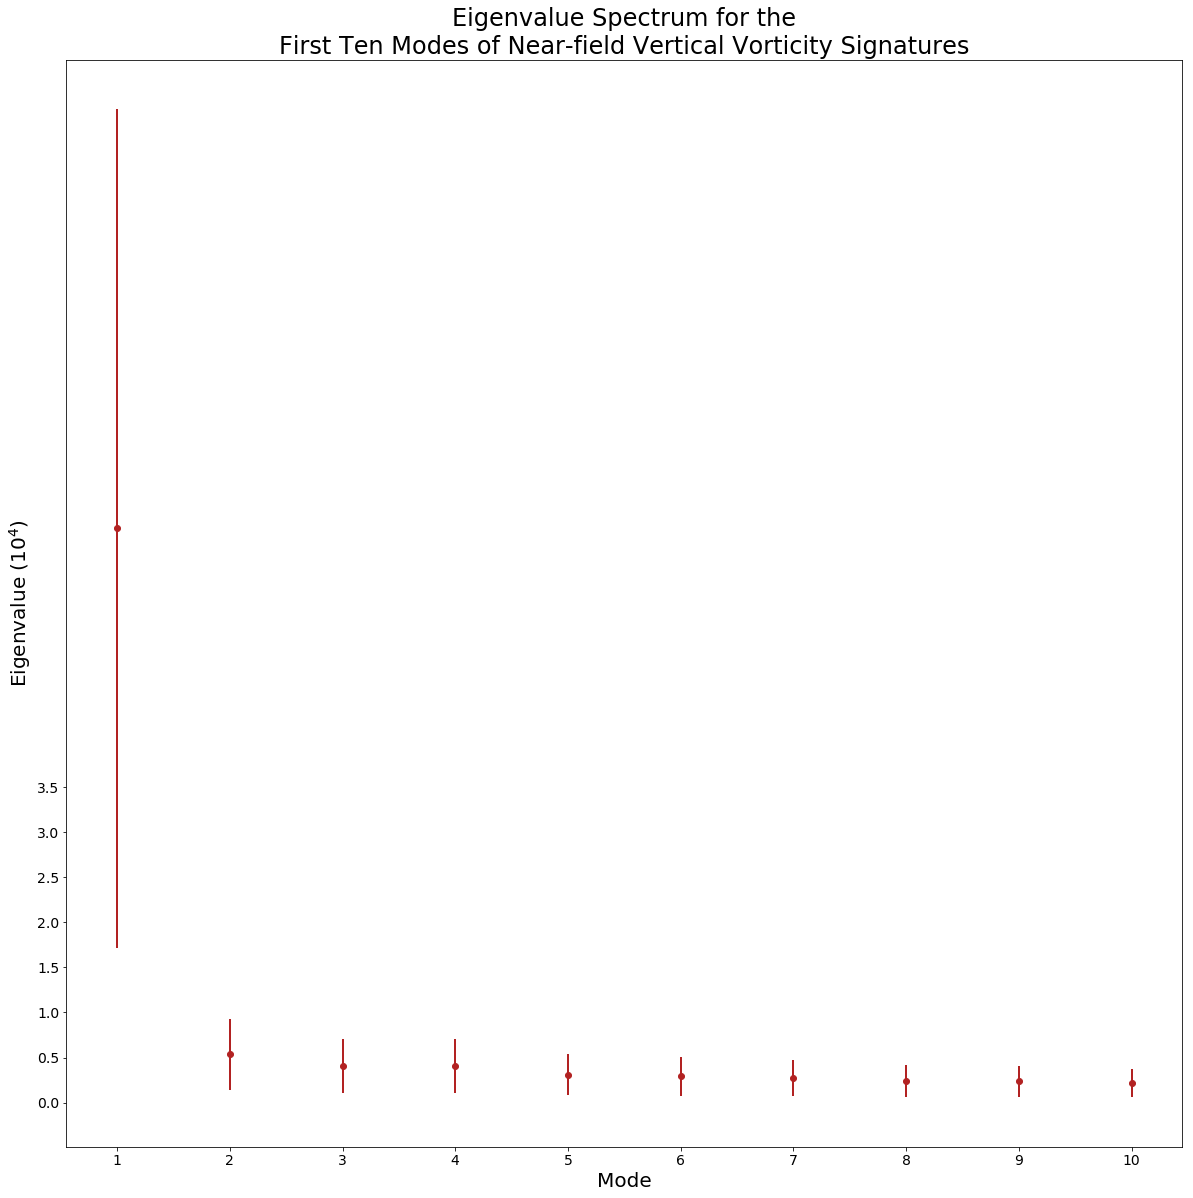

In [10]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title('Eigenvalue Spectrum for the\nFirst Ten Modes of Near-field Vertical Vorticity Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues]*10000,yerr=deltaLambda[:numValues]*10000,color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,4.0,0.5),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel(r'Eigenvalue ($10^{4}$)',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/nf_zvort_eigs',dpi=300)

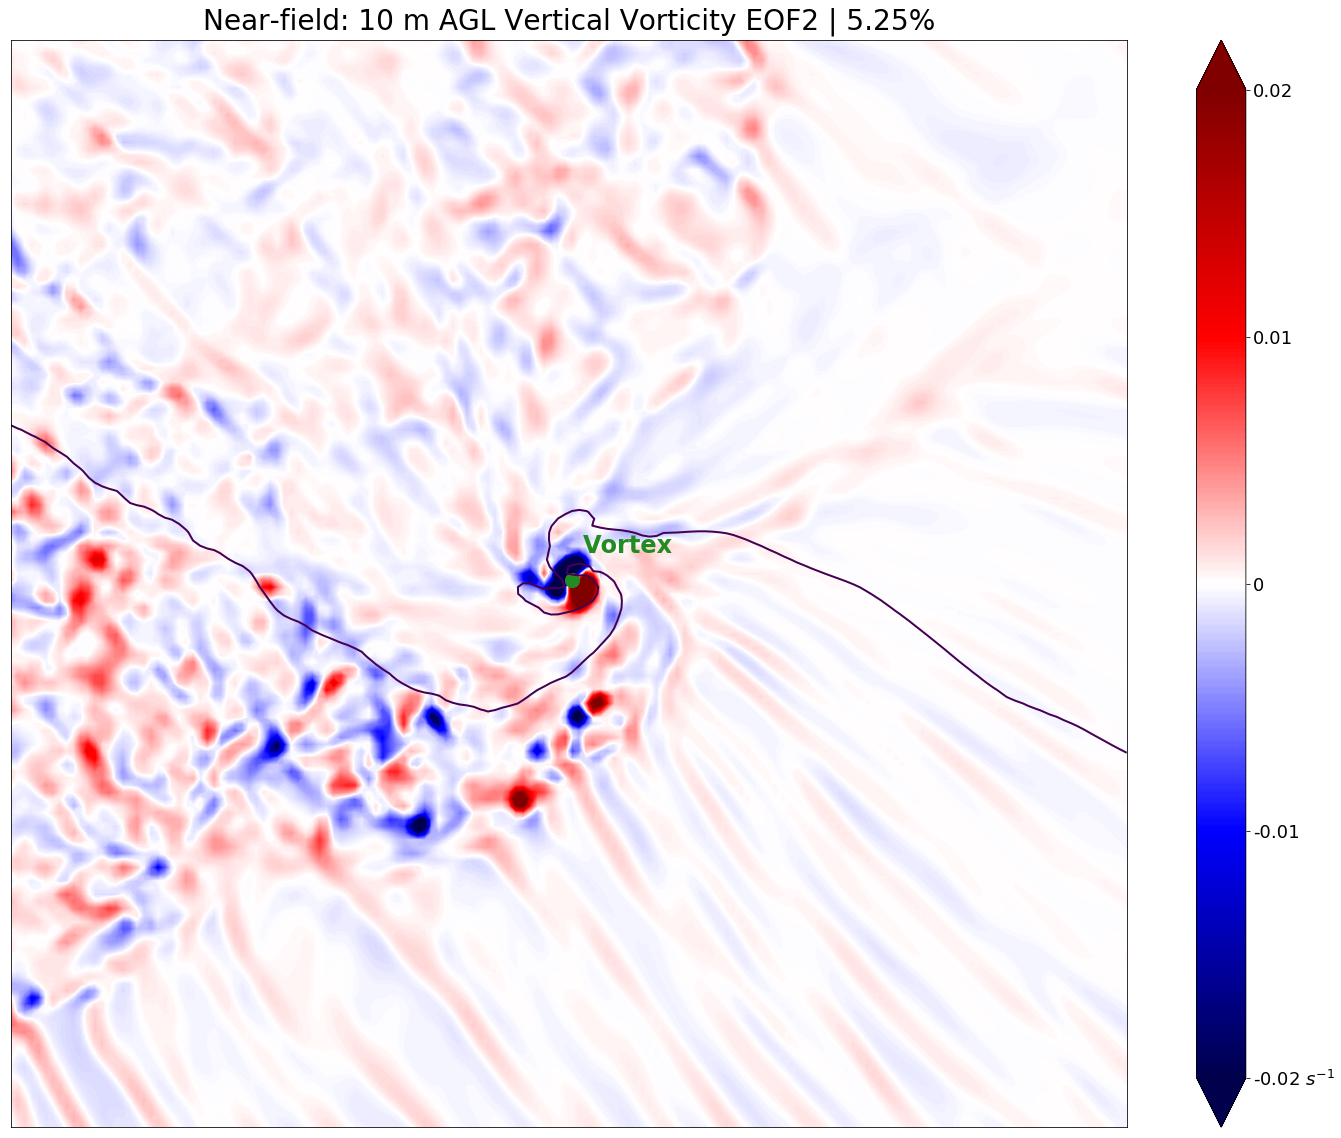

In [11]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 1

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_nf_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF ---
levels = np.arange(-0.02,0.0201,0.0001)
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

plt.xticks([],[])
plt.yticks([],[])

cbar = plt.colorbar(ticks=np.arange(-0.02,0.03,0.01))
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-0.02 $s^{-1}$','-0.01','0','0.01','0.02'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='forestgreen')
plt.text(dist+8,dist+4,'Vortex',color='forestgreen',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = 'Near-field: 10 m AGL Vertical Vorticity EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/CM1/plots/far_and_near_field_ensembles_rerun/nf_zvort_EOF'+str(mode+1),dpi=300)






In [12]:
#====================================================================
# Conduct EOF analysis (10 m AGL vertical vorticity.)
#====================================================================

#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- Second, far-field ---
A = zvort_ff_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)






U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [53.86592736  6.83844485  5.16716206  4.33728847  3.9905025   3.65292243
  3.46950102  3.03086824  2.72248112  2.55002906  2.40999349  2.16737715
  2.1081595   2.04191312  1.64742966]


Text(0, 0.5, 'Eigenvalue ($10^{4}$)')

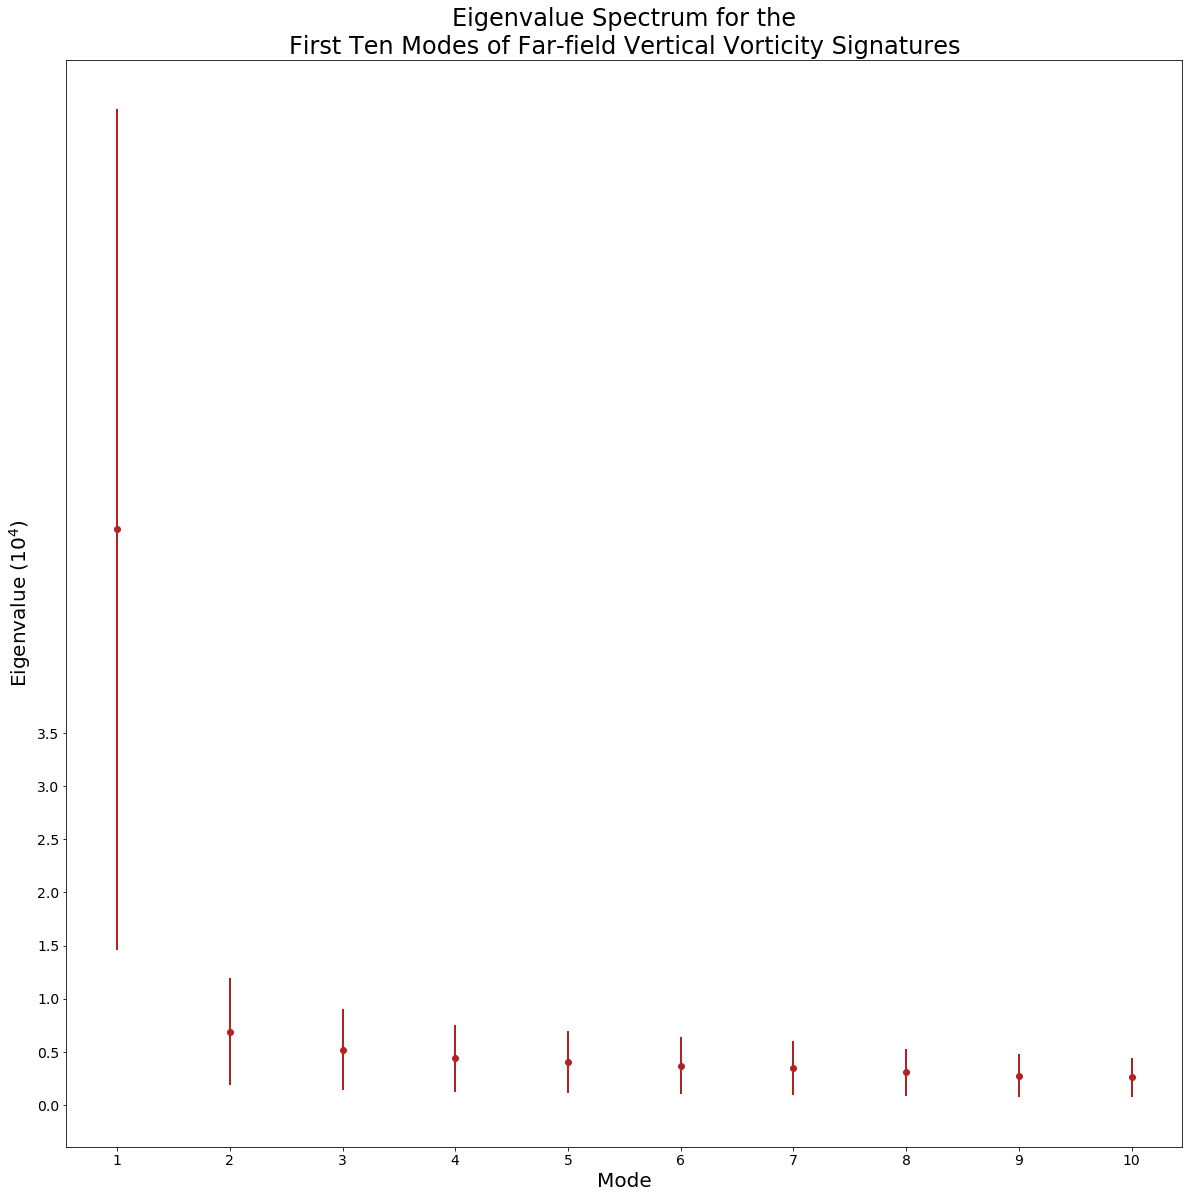

In [13]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title('Eigenvalue Spectrum for the\nFirst Ten Modes of Far-field Vertical Vorticity Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues]*10000,yerr=deltaLambda[:numValues]*10000,color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,4.0,0.5),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel(r'Eigenvalue ($10^{4}$)',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/ff_zvort_eigs',dpi=300)

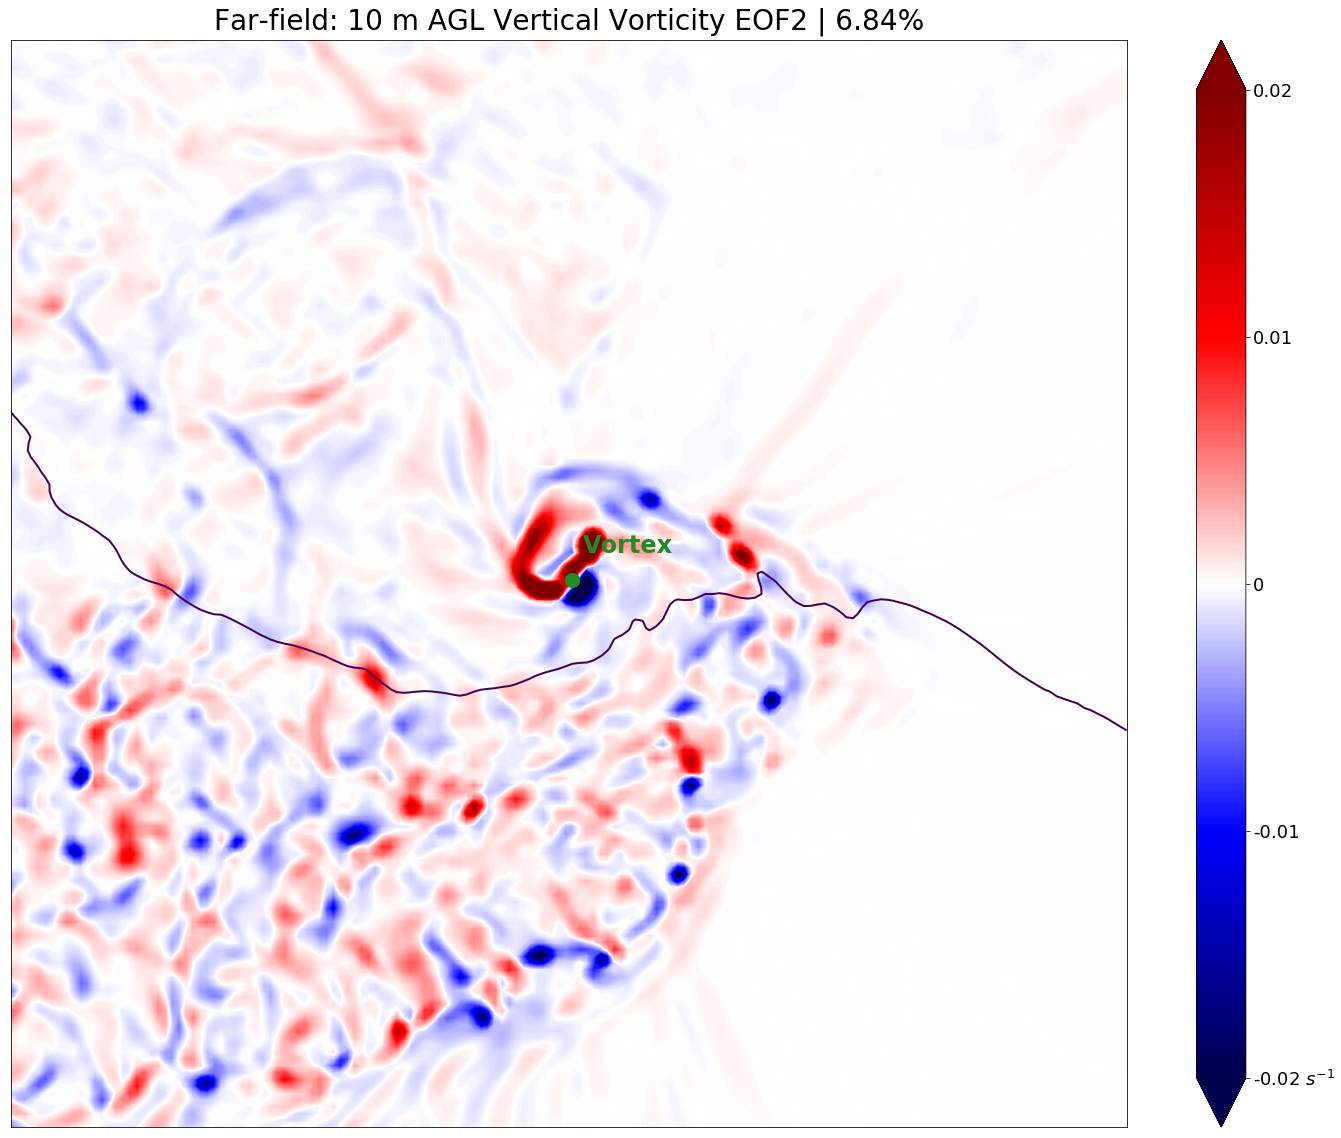

In [14]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 1

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_ff_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF ---
levels = np.arange(-0.02,0.0201,0.0001)
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

plt.xticks([],[])
plt.yticks([],[])

cbar = plt.colorbar(ticks=np.arange(-0.02,0.03,0.01))
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-0.02 $s^{-1}$','-0.01','0','0.01','0.02'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='forestgreen')
plt.text(dist+8,dist+4,'Vortex',color='forestgreen',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = 'Far-field: 10 m AGL Vertical Vorticity EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/CM1/plots/far_and_near_field_ensembles_rerun/ff_zvort_EOF'+str(mode+1),dpi=300)








In [22]:
#====================================================================
# Conduct EOF analysis (10 m AGL thetarho).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field ---
A = thetarho_nf_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)







U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [92.32644947  2.37854643  1.37904182  0.70460252  0.64797478  0.45549531
  0.42693885  0.32733543  0.27717544  0.26217602  0.22810108  0.17521585
  0.16045504  0.13989854  0.1105934 ]


Text(0, 0.5, 'Eigenvalue')

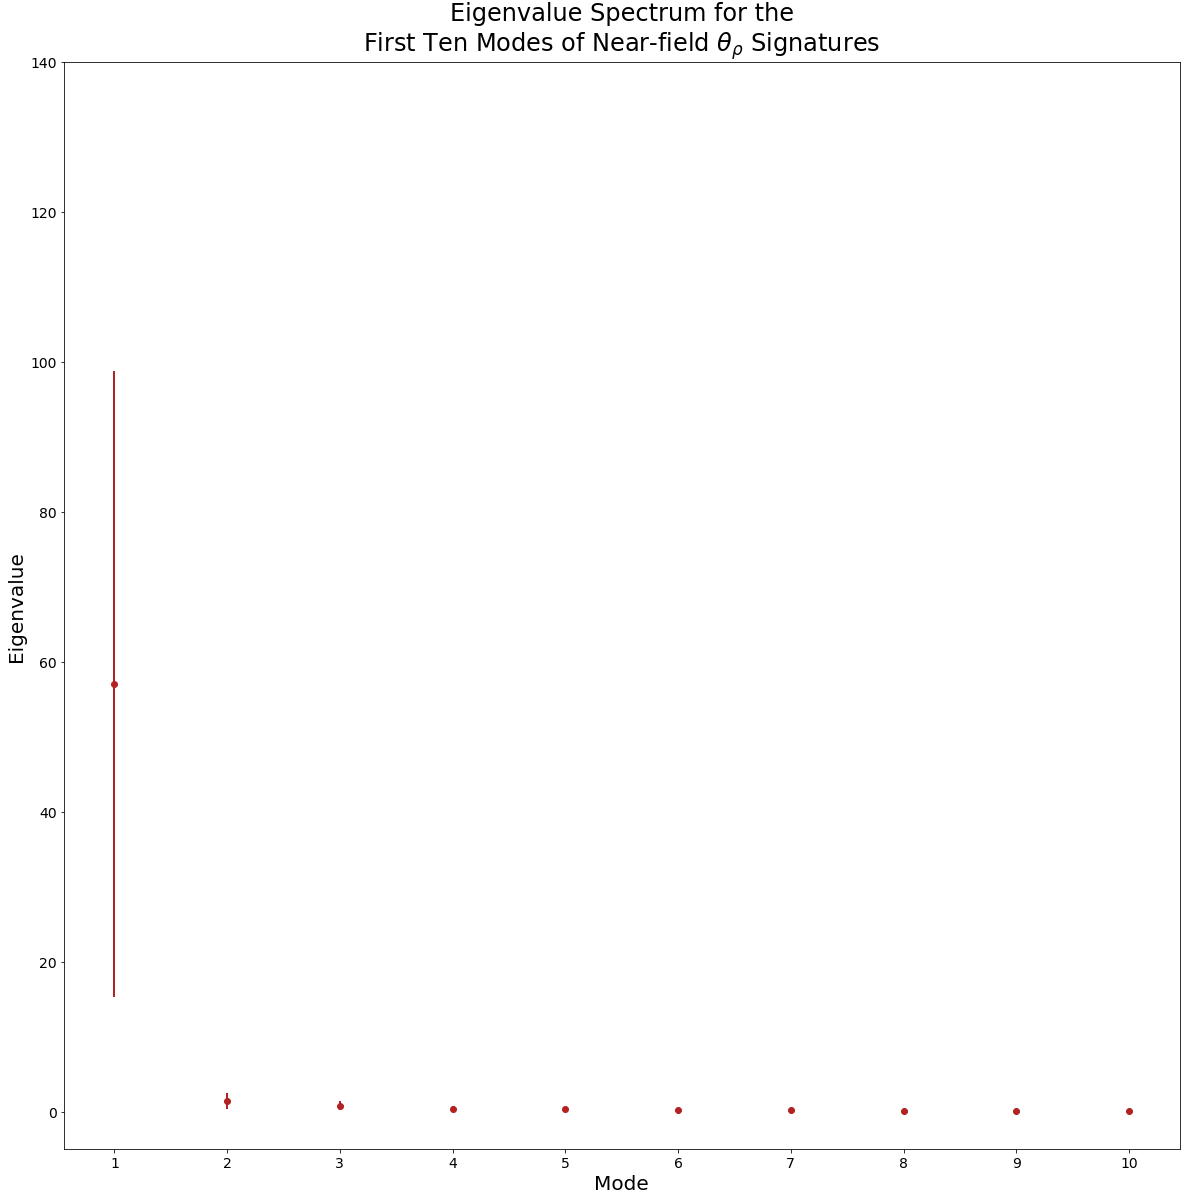

In [23]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title(r'Eigenvalue Spectrum for the'+'\n'+r'First Ten Modes of Near-field $\theta_\rho$ Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues],yerr=deltaLambda[:numValues],color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,160,20),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel(r'Eigenvalue',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/nf_thetarho_eigs',dpi=300)

Text(0.5, 1.005, 'Near-field: 10 m AGL $\\theta_\\rho$ EOF1 | 92.33%')

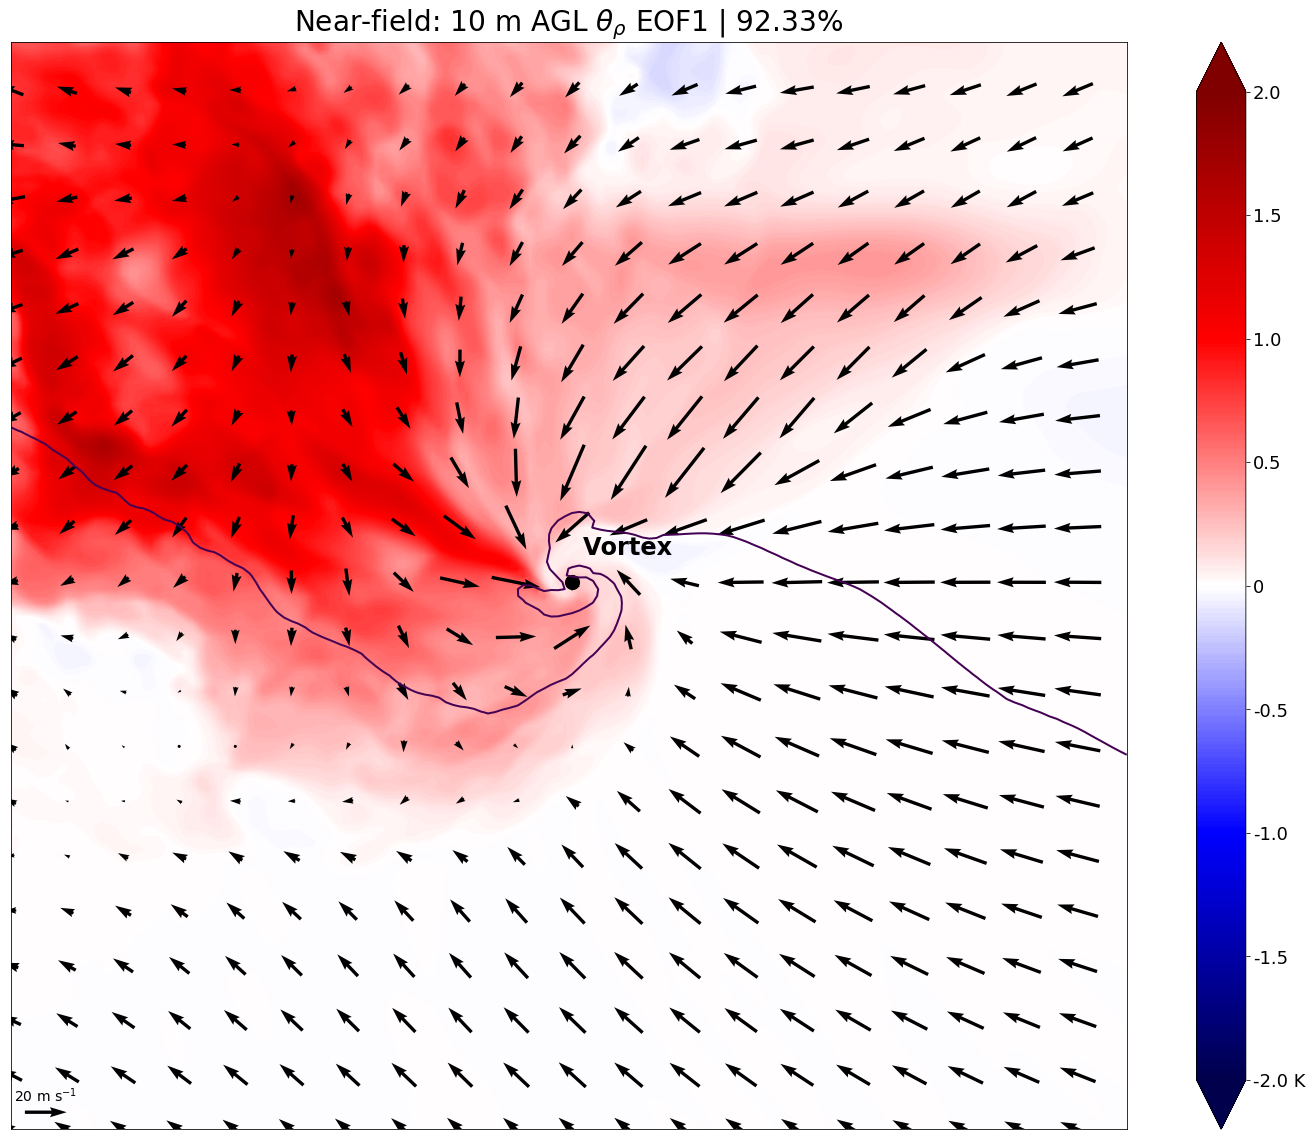

In [24]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 0

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_nf_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF ---
levels = np.arange(-2.0,2.01,0.01)
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

plt.xticks([],[])
plt.yticks([],[])

ticks=np.arange(-2.0,2.5,0.5)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-2.0 K','-1.5','-1.0','-0.5','0','0.5','1.0','1.5','2.0'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist+8,dist+4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Plot storm-relative 10 m AGL winds.
#------------------------------------------------------
inc = 8
    
x_arrows, y_arrows = np.meshgrid(np.arange(0,EOFs.shape[2],inc),np.arange(0,EOFs.shape[1],inc))
    
arrows = plt.quiver(x_arrows,y_arrows,u_sr_nf_comp[::inc,::inc],\
                    v_sr_nf_comp[::inc,::inc],\
                    pivot='mid')
    
# ----- creating the reference vector -----
plt.quiverkey(arrows,5,2.5,20,'20 m s$^{-1}$',coordinates='data',facecolor='black',\
             fontproperties={'size': 14})
    
# key_text_x = 536
# key_text_y = 335
# key_text   = '10 m AGL'
# plt.text(key_text_x,key_text_y,\
#              key_text,\
#              fontsize=10,\
#              color='black',\
#              ha='center',\
#              va='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = r'Near-field: 10 m AGL $\theta_\rho$ EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/nf_thetarho_EOF'+str(mode+1),dpi=300)









In [25]:
#====================================================================
# Conduct EOF analysis (10 m AGL thetarho).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
# u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
# v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

# u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
# v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- Second, far-field ---
A = thetarho_ff_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)








U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [88.01810256  3.67738701  2.22399233  1.47503961  0.85165842  0.76689735
  0.6009211   0.46760957  0.42207124  0.35464574  0.31775504  0.25057412
  0.21776945  0.20957729  0.14599917]


Text(0, 0.5, 'Eigenvalue')

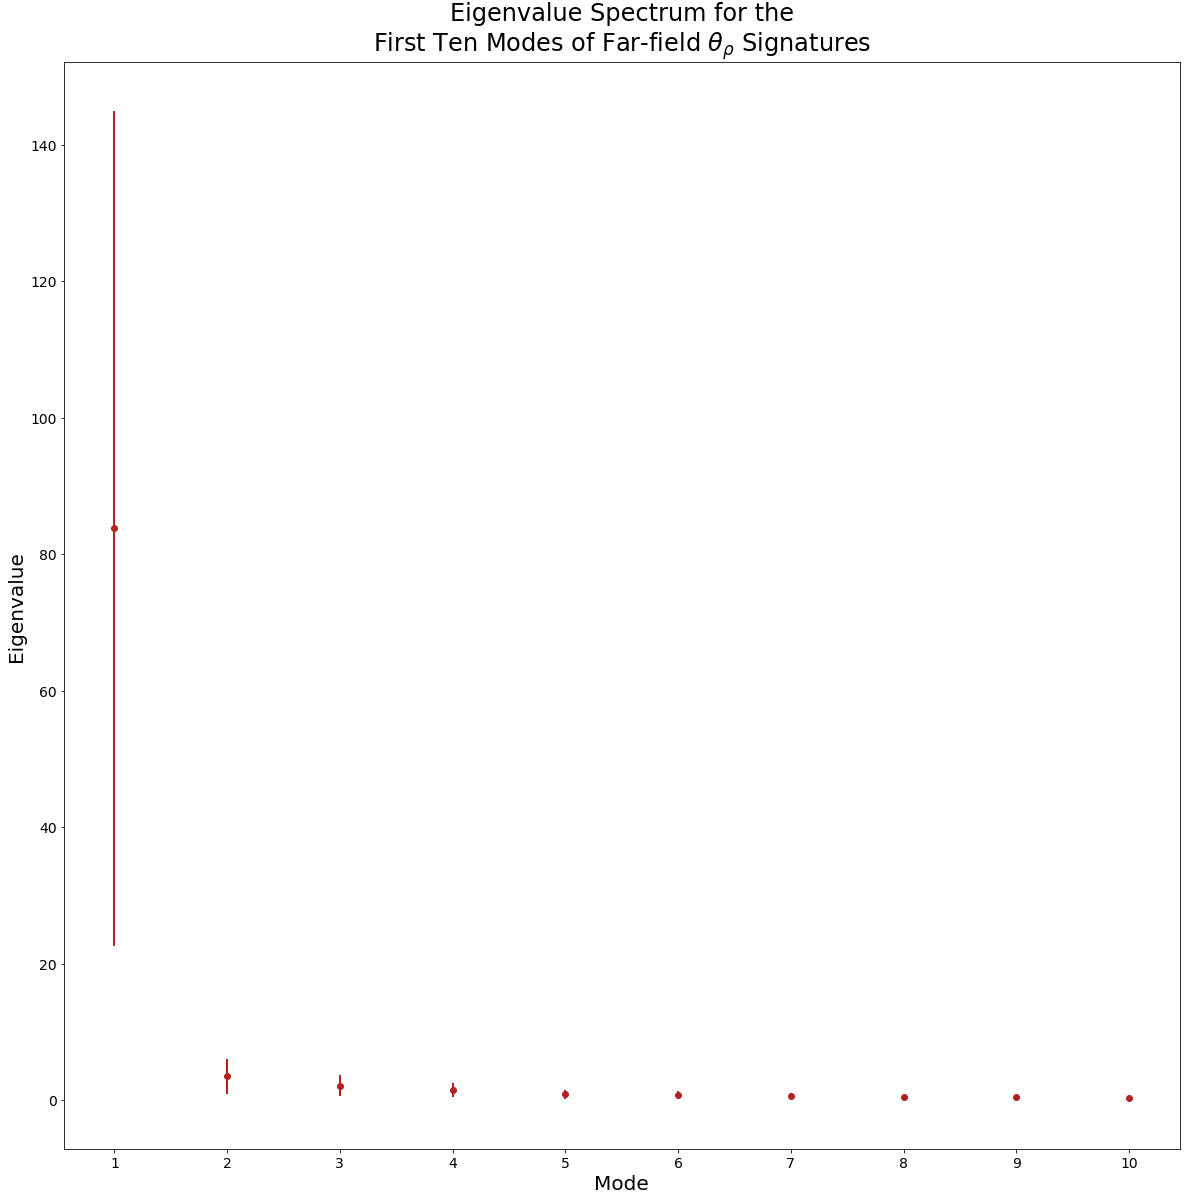

In [26]:
#====================================================================
# Now plot the eigenvalue spectrum!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

numValues = 10

N = num_ens # each ensemble is an independent sample
deltaLambda = eigval*np.sqrt(2/float(N))*2

plt.title(r'Eigenvalue Spectrum for the'+'\n'+r'First Ten Modes of Far-field $\theta_\rho$ Signatures',fontsize=24)
plt.errorbar(np.arange(1,numValues+1),eigval[:numValues],yerr=deltaLambda[:numValues],color='firebrick',fmt='o',linewidth=2)
plt.xticks(np.arange(1,numValues+1),fontsize=14)
plt.yticks(np.arange(0,160,20),fontsize=14)
plt.xlabel('Mode',fontsize=20)
plt.ylabel(r'Eigenvalue',fontsize=20)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/ff_thetarho_eigs',dpi=300)

Text(0.5, 1.005, 'Far-field: 10 m AGL $\\theta_\\rho$ EOF1 | 88.02%')

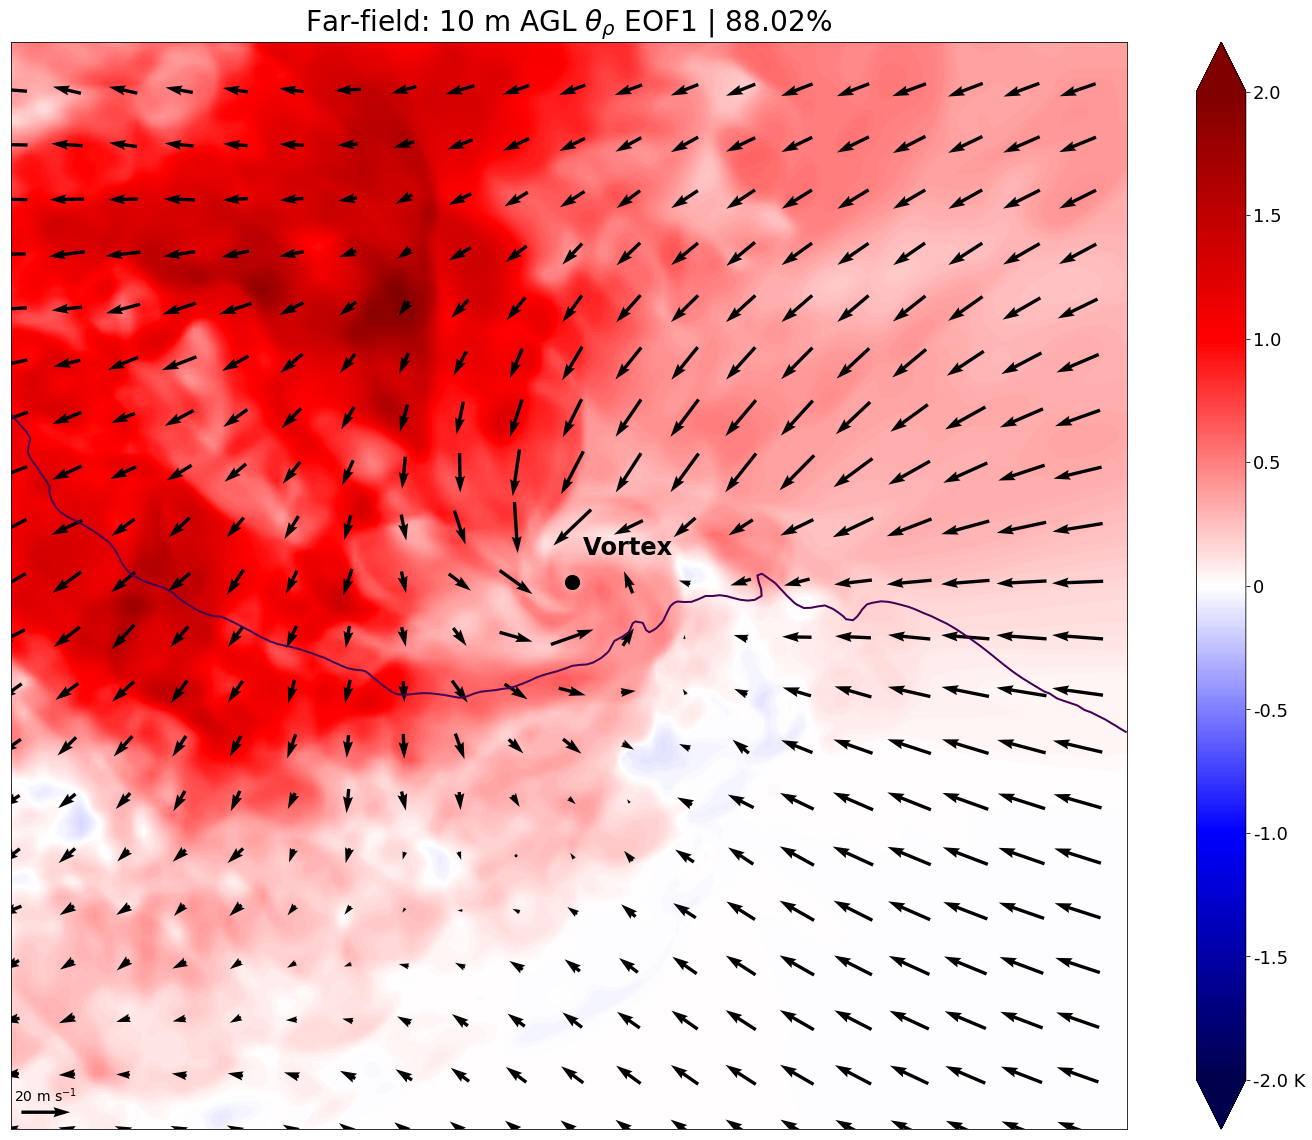

In [27]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 0

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_ff_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF ---
levels = np.arange(-2.0,2.01,0.01)
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

plt.xticks([],[])
plt.yticks([],[])

ticks=np.arange(-2.0,2.5,0.5)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-2.0 K','-1.5','-1.0','-0.5','0','0.5','1.0','1.5','2.0'])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist+8,dist+4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Plot storm-relative 10 m AGL winds.
#------------------------------------------------------
inc = 8
    
x_arrows, y_arrows = np.meshgrid(np.arange(0,EOFs.shape[2],inc),np.arange(0,EOFs.shape[1],inc))
    
arrows = plt.quiver(x_arrows,y_arrows,u_sr_ff_comp[::inc,::inc],\
                    v_sr_ff_comp[::inc,::inc],\
                    pivot='mid')
    
# ----- creating the reference vector -----
plt.quiverkey(arrows,5,2.5,20,'20 m s$^{-1}$',coordinates='data',facecolor='black',\
             fontproperties={'size': 14})
    
# key_text_x = 536
# key_text_y = 335
# key_text   = '10 m AGL'
# plt.text(key_text_x,key_text_y,\
#              key_text,\
#              fontsize=10,\
#              color='black',\
#              ha='center',\
#              va='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = r'Far-field: 10 m AGL $\theta_\rho$ EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/ff_thetarho_EOF'+str(mode+1),dpi=300)










In [28]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field u ---
A = u_sr_nf_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_u = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_u = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp_u = np.ones(np.size(eigval_u))*np.nan

for i in np.arange(0,np.size(varExp_u)):
    varExp_u[i] = eigval_u[i]/np.sum(eigval_u) * 100.
    
print('Variance explained: ',varExp_u)








U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [95.4601474   1.0727232   0.71068096  0.48301832  0.36817902  0.30129287
  0.28050626  0.23203779  0.2081852   0.19471186  0.18212879  0.15558041
  0.13329136  0.11275101  0.10476557]


In [29]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field v ---
A = v_sr_nf_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_v = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_v = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs_v))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_v))

varExp_v = np.ones(np.size(eigval_v))*np.nan

for i in np.arange(0,np.size(varExp_v)):
    varExp_v[i] = eigval_v[i]/np.sum(eigval_v) * 100.
    
print('Variance explained: ',varExp_v)









U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [88.30876077  2.51304594  1.98656969  1.55166135  0.96294353  0.74060611
  0.67882008  0.59532717  0.54347369  0.48477186  0.39401005  0.37029045
  0.31548077  0.28768008  0.26655843]


In [31]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field wind magnitude ---
A = ((u_sr_nf_2d)**2. + (v_sr_nf_2d)**2.)**(0.5)

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_uv = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_uvmag = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

# print('EOFs: ',np.shape(EOFs_uv))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_uv))

varExp_uv = np.ones(np.size(eigval_uv))*np.nan

for i in np.arange(0,np.size(varExp_uv)):
    varExp_uv[i] = eigval_uv[i]/np.sum(eigval_uv) * 100.
    
print('Variance explained: ',varExp_uv)










U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
Eigval shape:  (15,)
Variance explained:  [9.74849432e+01 5.87092766e-01 3.62508553e-01 2.94906631e-01
 1.81854069e-01 1.70500869e-01 1.50806442e-01 1.36799263e-01
 1.25935659e-01 1.04535387e-01 9.71553719e-02 8.88518129e-02
 8.42190615e-02 7.64068411e-02 5.34840230e-02]


In [33]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field wind direction ---
A = 180. + 180./np.pi*np.arctan(u_sr_nf_2d,v_sr_nf_2d)

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_uv = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_uvdir = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

# print('EOFs: ',np.shape(EOFs_uv))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_uv))

varExp_uv = np.ones(np.size(eigval_uv))*np.nan

for i in np.arange(0,np.size(varExp_uv)):
    varExp_uv[i] = eigval_uv[i]/np.sum(eigval_uv) * 100.
    
print('Variance explained: ',varExp_uv)











U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
Eigval shape:  (15,)
Variance explained:  [95.36704383  1.07750101  0.6384362   0.51090303  0.32459563  0.3145405
  0.29822984  0.26680581  0.24069061  0.21726875  0.17242574  0.1557953
  0.14497258  0.14275708  0.12803411]


Text(0.5, 1.005, 'Near-field: 10 m AGL Winds EOF1 | 88.02%')

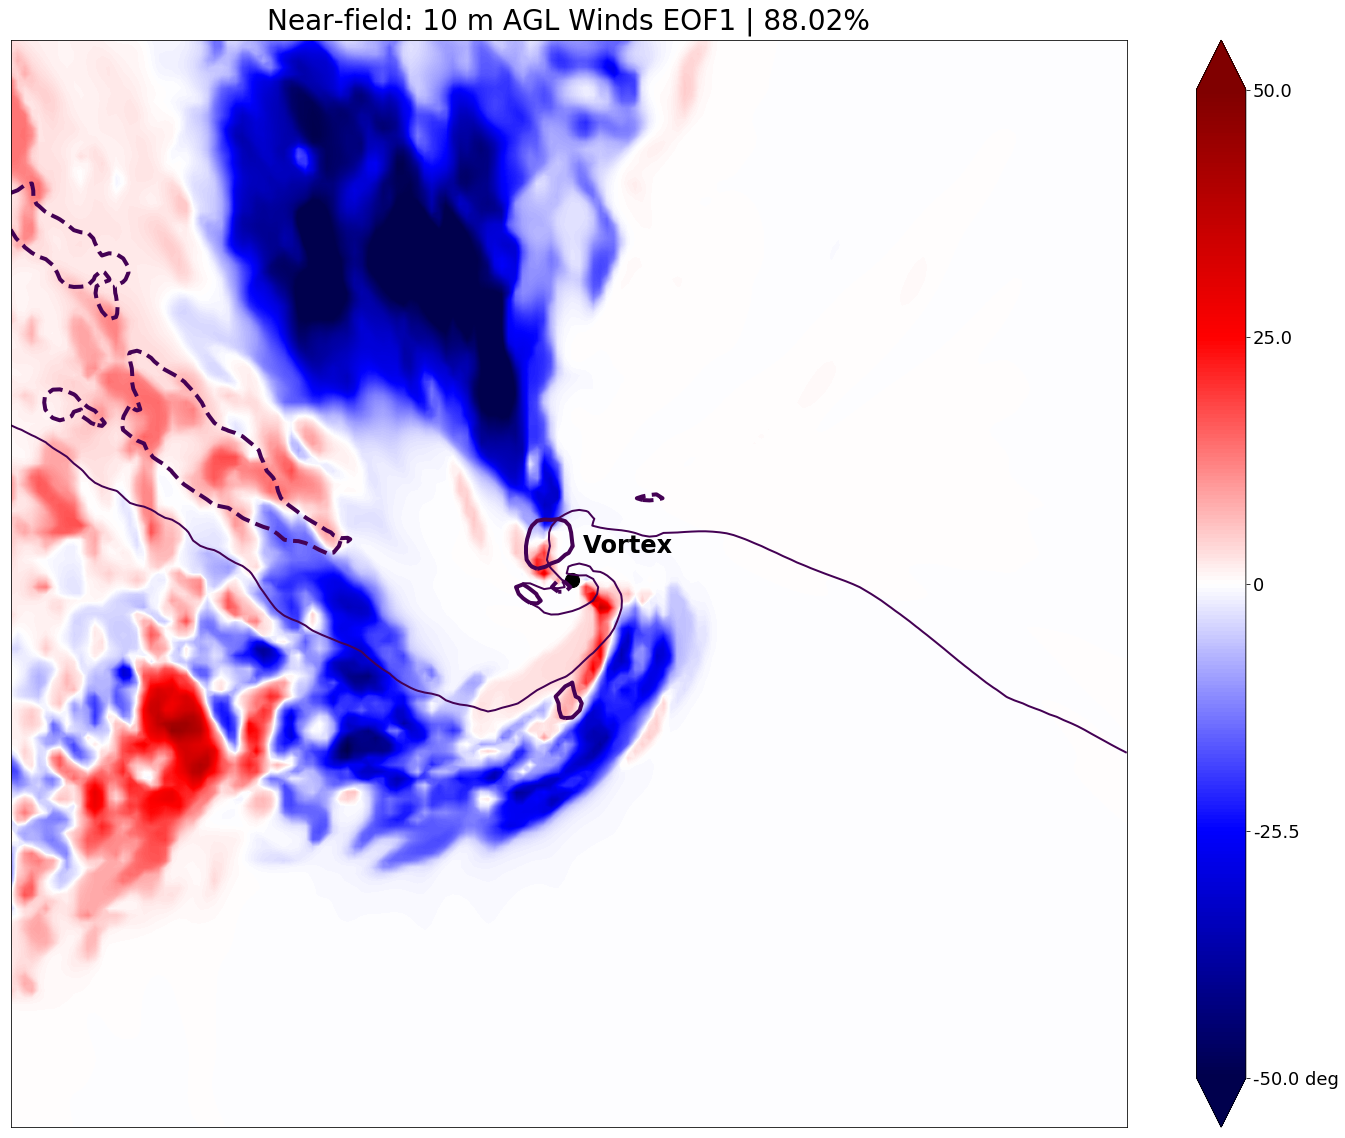

In [34]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs_v.shape[1])
y = np.arange(0,EOFs_v.shape[2])

# --- Which mode do we want to plot? ---
mode = 0

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_nf_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF direction (filled) ---
levels = np.arange(-50.0,50.1,0.1)
plt.contourf(x,y,EOFs_uvdir[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

ticks=np.arange(-50.0,75.0,25.0)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-50.0 deg','-25.5','0','25.0','50.0'])

# --- EOF magnitude (contoured) ---
plt.contour(x,y,EOFs_uvmag[mode,:,:],'k',linestyles='dashed',levels=[-3.0],linewidths=4)
plt.contour(x,y,EOFs_uvmag[mode,:,:],'k',levels=[3.0],linewidths=4)

plt.xticks([],[])
plt.yticks([],[])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist+8,dist+4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Plot desired EOF mode of u/v components.
#------------------------------------------------------
# inc = 8
    
# x_arrows, y_arrows = np.meshgrid(np.arange(0,EOFs_u.shape[2],inc),np.arange(0,EOFs_u.shape[1],inc))
    
# print(x_arrows.shape)
# print(EOFs_u.shape)
# arrows = plt.quiver(x_arrows,y_arrows,EOFs_u[mode,::inc,::inc],\
#                     EOFs_v[mode,::inc,::inc],\
#                     pivot='mid')
    
# # ----- creating the reference vector -----
# plt.quiverkey(arrows,8,2.5,5,'5 m s$^{-1}$',coordinates='data',facecolor='black',\
#              fontproperties={'size': 14})
    
# key_text_x = 536
# key_text_y = 335
# key_text   = '10 m AGL'
# plt.text(key_text_x,key_text_y,\
#              key_text,\
#              fontsize=10,\
#              color='black',\
#              ha='center',\
#              va='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = r'Near-field: 10 m AGL Winds EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/nf_uv_EOF'+str(mode+1),dpi=300)











In [35]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- Far, far-field wind magnitude ---
A = ((u_sr_ff_2d)**2. + (v_sr_ff_2d)**2.)**(0.5)

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_uv = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_uvmag = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

# print('EOFs: ',np.shape(EOFs_uv))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_uv))

varExp_uv = np.ones(np.size(eigval_uv))*np.nan

for i in np.arange(0,np.size(varExp_uv)):
    varExp_uv[i] = eigval_uv[i]/np.sum(eigval_uv) * 100.
    
print('Variance explained: ',varExp_uv)











U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
Eigval shape:  (15,)
Variance explained:  [93.7549555   1.67934743  0.81659276  0.64236588  0.46002466  0.43472368
  0.38504884  0.3366373   0.28080507  0.27440561  0.2578287   0.20082669
  0.19170855  0.17213823  0.1125911 ]


In [36]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- Second, far-field wind direction ---
A = 180. + 180./np.pi*np.arctan(u_sr_ff_2d,v_sr_ff_2d)

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_uv = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_uvdir = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

# print('EOFs: ',np.shape(EOFs_uv))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_uv))

varExp_uv = np.ones(np.size(eigval_uv))*np.nan

for i in np.arange(0,np.size(varExp_uv)):
    varExp_uv[i] = eigval_uv[i]/np.sum(eigval_uv) * 100.
    
print('Variance explained: ',varExp_uv)












U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
Eigval shape:  (15,)
Variance explained:  [92.84415755  2.26085411  0.82331241  0.72687224  0.48224828  0.46626604
  0.42748343  0.32715506  0.30784212  0.27926322  0.26047716  0.24545926
  0.23384127  0.16552911  0.14923873]


Text(0.5, 1.005, 'Far-field: 10 m AGL Winds EOF3 | 2.22%')

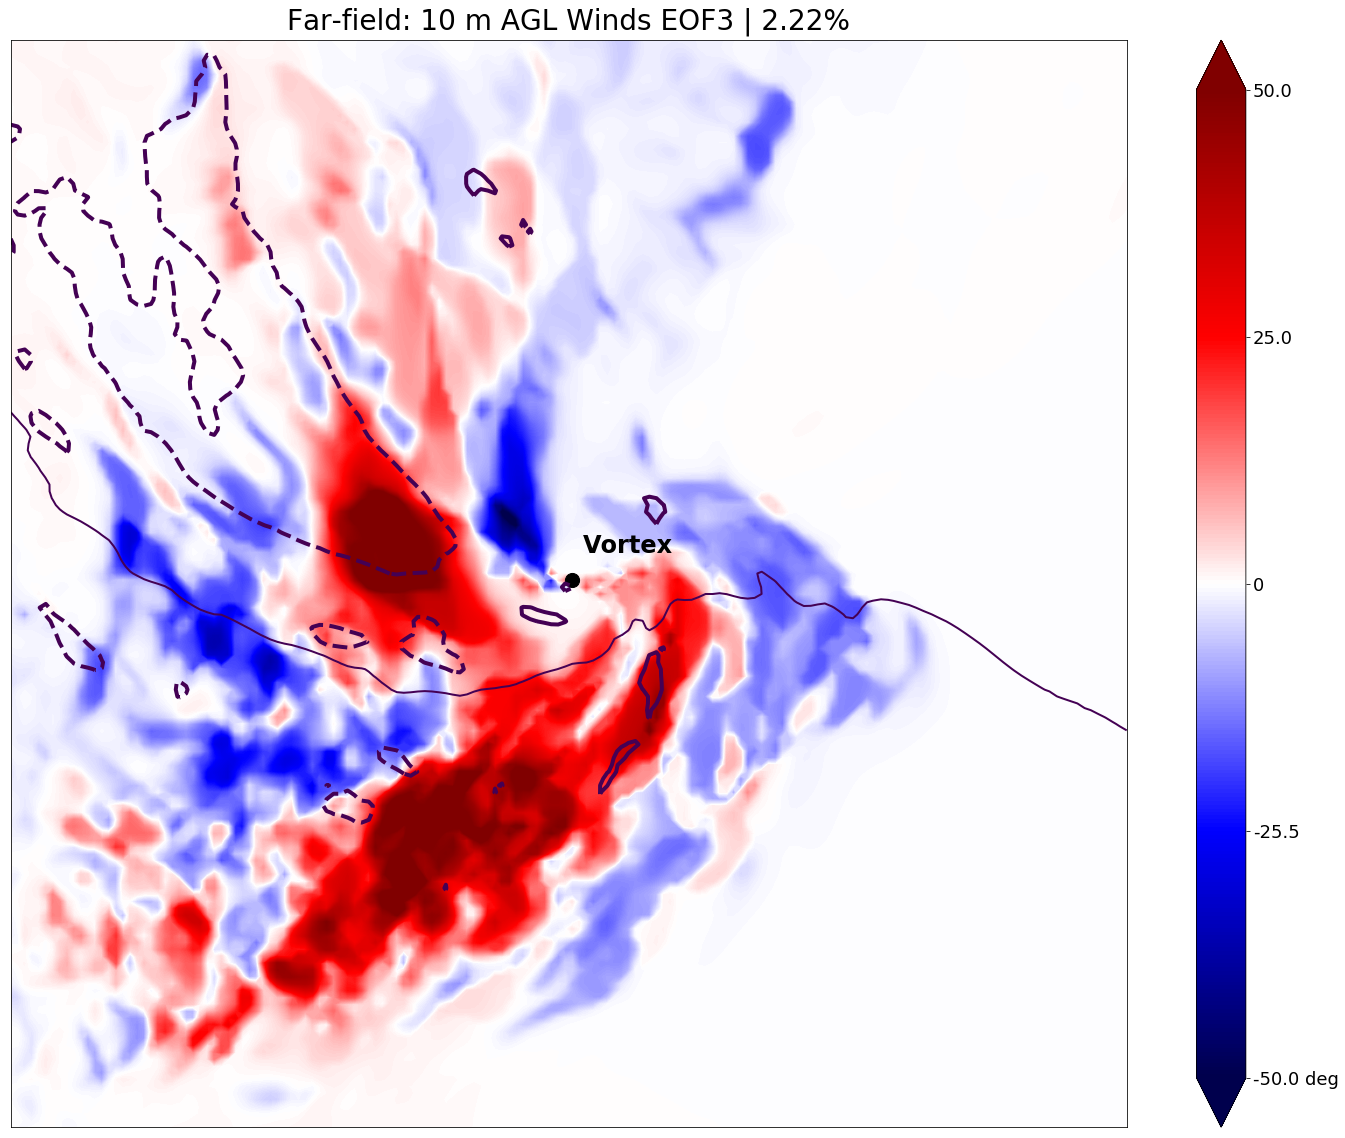

In [37]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs_v.shape[1])
y = np.arange(0,EOFs_v.shape[2])

# --- Which mode do we want to plot? ---
mode = 2

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_ff_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF direction (filled) ---
levels = np.arange(-50.0,50.1,0.1)
plt.contourf(x,y,EOFs_uvdir[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

ticks=np.arange(-50.0,75.0,25.0)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-50.0 deg','-25.5','0','25.0','50.0'])

# --- EOF magnitude (contoured) ---
plt.contour(x,y,EOFs_uvmag[mode,:,:],'k',linestyles='dashed',levels=[-3.0],linewidths=4)
plt.contour(x,y,EOFs_uvmag[mode,:,:],'k',levels=[3.0],linewidths=4)

plt.xticks([],[])
plt.yticks([],[])

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist+8,dist+4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Plot desired EOF mode of u/v components.
#------------------------------------------------------
# inc = 8
    
# x_arrows, y_arrows = np.meshgrid(np.arange(0,EOFs_u.shape[2],inc),np.arange(0,EOFs_u.shape[1],inc))
    
# print(x_arrows.shape)
# print(EOFs_u.shape)
# arrows = plt.quiver(x_arrows,y_arrows,EOFs_u[mode,::inc,::inc],\
#                     EOFs_v[mode,::inc,::inc],\
#                     pivot='mid')
    
# # ----- creating the reference vector -----
# plt.quiverkey(arrows,8,2.5,5,'5 m s$^{-1}$',coordinates='data',facecolor='black',\
#              fontproperties={'size': 14})
    
# key_text_x = 536
# key_text_y = 335
# key_text   = '10 m AGL'
# plt.text(key_text_x,key_text_y,\
#              key_text,\
#              fontsize=10,\
#              color='black',\
#              ha='center',\
#              va='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = r'Far-field: 10 m AGL Winds EOF' + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

# plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/Adv_Stats/plots/ff_uv_EOF'+str(mode+1),dpi=300)












In [46]:
#===============================================================
# Now plot the thetarho EOF modes (shaded) with the wind
# direction EOF modes (contoured).
#
# THIS IS WHAT IS USED IN THE PAPER. Just change this code from
# near-field to far-field and vice versa and you're good.
#===============================================================

In [50]:
#====================================================================
# Conduct EOF analysis (10 m AGL thetarho).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field ---
A = thetarho_ff_2d

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

print('EOFs: ',np.shape(EOFs))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval))

varExp = np.ones(np.size(eigval))*np.nan

for i in np.arange(0,np.size(varExp)):
    varExp[i] = eigval[i]/np.sum(eigval) * 100.
    
print('Variance explained: ',varExp)








U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
EOFs:  (15, 160, 160)
Eigval shape:  (15,)
Variance explained:  [88.01810256  3.67738701  2.22399233  1.47503961  0.85165842  0.76689735
  0.6009211   0.46760957  0.42207124  0.35464574  0.31775504  0.25057412
  0.21776945  0.20957729  0.14599917]


In [51]:
#====================================================================
# Conduct EOF analysis (10 m AGL storm-relative winds).
#====================================================================

#--------------------------------------------------------------------
# Compute time-mean of u/v winds to plot.
#--------------------------------------------------------------------
u_sr_nf_comp = np.mean(u_sr_nf,axis=0)
v_sr_nf_comp = np.mean(v_sr_nf,axis=0)

u_sr_ff_comp = np.mean(u_sr_ff,axis=0)
v_sr_ff_comp = np.mean(v_sr_ff,axis=0)



#--------------------------------------------------------------------
# First, reshape the arrays to (ensemble member) x (space).
#--------------------------------------------------------------------
num_ens,num_x,num_y = refl_nf.shape

refl_nf_2d = refl_nf.reshape(num_ens,num_x*num_y,order='F')
w_nf_2d = w_nf.reshape(num_ens,num_x*num_y,order='F')
zvort_nf_2d = zvort_nf.reshape(num_ens,num_x*num_y,order='F')
thetarho_nf_2d = thetarho_nf.reshape(num_ens,num_x*num_y,order='F')
u_sr_nf_2d = u_sr_nf.reshape(num_ens,num_x*num_y,order='F')
v_sr_nf_2d = v_sr_nf.reshape(num_ens,num_x*num_y,order='F')

refl_ff_2d = refl_ff.reshape(num_ens,num_x*num_y,order='F')
w_ff_2d = w_ff.reshape(num_ens,num_x*num_y,order='F')
zvort_ff_2d = zvort_ff.reshape(num_ens,num_x*num_y,order='F')
thetarho_ff_2d = thetarho_ff.reshape(num_ens,num_x*num_y,order='F')
u_sr_ff_2d = u_sr_ff.reshape(num_ens,num_x*num_y,order='F')
v_sr_ff_2d = v_sr_ff.reshape(num_ens,num_x*num_y,order='F')

#--------------------------------------------------------------------
# SVD technique for both ensembles.
#--------------------------------------------------------------------

# --- First, near-field wind direction ---
A = 180. + 180./np.pi*np.arctan(u_sr_ff_2d,v_sr_ff_2d)

U,S,V = np.linalg.svd(A)

print('U:',U.shape)
print('S:',S.shape)
print('V:',V.shape)


PCs = U
EOFs_nounits = V

print('A:',A.shape)
print('PCs:',PCs.shape)

eigval_uv = S**2/float(num_x*num_y) # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
           # Also, you must scale squared values of the sigma matrix by
           # the sample size (i.e., the column size of A) to get the actual eigenvalues.

#plt.imshow(EOFs_nounits[0,:])

#====================================================================
# Standardize the PCs.
#====================================================================
stdPCs = (PCs - np.mean(PCs,axis=0))/np.std(PCs,axis=0)

#====================================================================
# Regress the original data onto each PC to produce maps with
# the original units (EOFs).
#====================================================================
regressPatterns_weirdshape = np.dot(stdPCs.T,A)/float(num_ens)

print('Regress patterns (weird shape): ',np.shape(regressPatterns_weirdshape))

EOFs_uvdir = regressPatterns_weirdshape.reshape((num_ens,num_x,num_y),order='F') #EOFs with amplitude

# print('EOFs: ',np.shape(EOFs_uv))

#====================================================================
# Calculate variance explained for each mode.
#====================================================================
print('Eigval shape: ',np.shape(eigval_uv))

varExp_uv = np.ones(np.size(eigval_uv))*np.nan

for i in np.arange(0,np.size(varExp_uv)):
    varExp_uv[i] = eigval_uv[i]/np.sum(eigval_uv) * 100.
    
print('Variance explained: ',varExp_uv)












U: (15, 15)
S: (15,)
V: (25600, 25600)
A: (15, 25600)
PCs: (15, 15)
Regress patterns (weird shape):  (15, 25600)
Eigval shape:  (15,)
Variance explained:  [92.84415755  2.26085411  0.82331241  0.72687224  0.48224828  0.46626604
  0.42748343  0.32715506  0.30784212  0.27926322  0.26047716  0.24545926
  0.23384127  0.16552911  0.14923873]


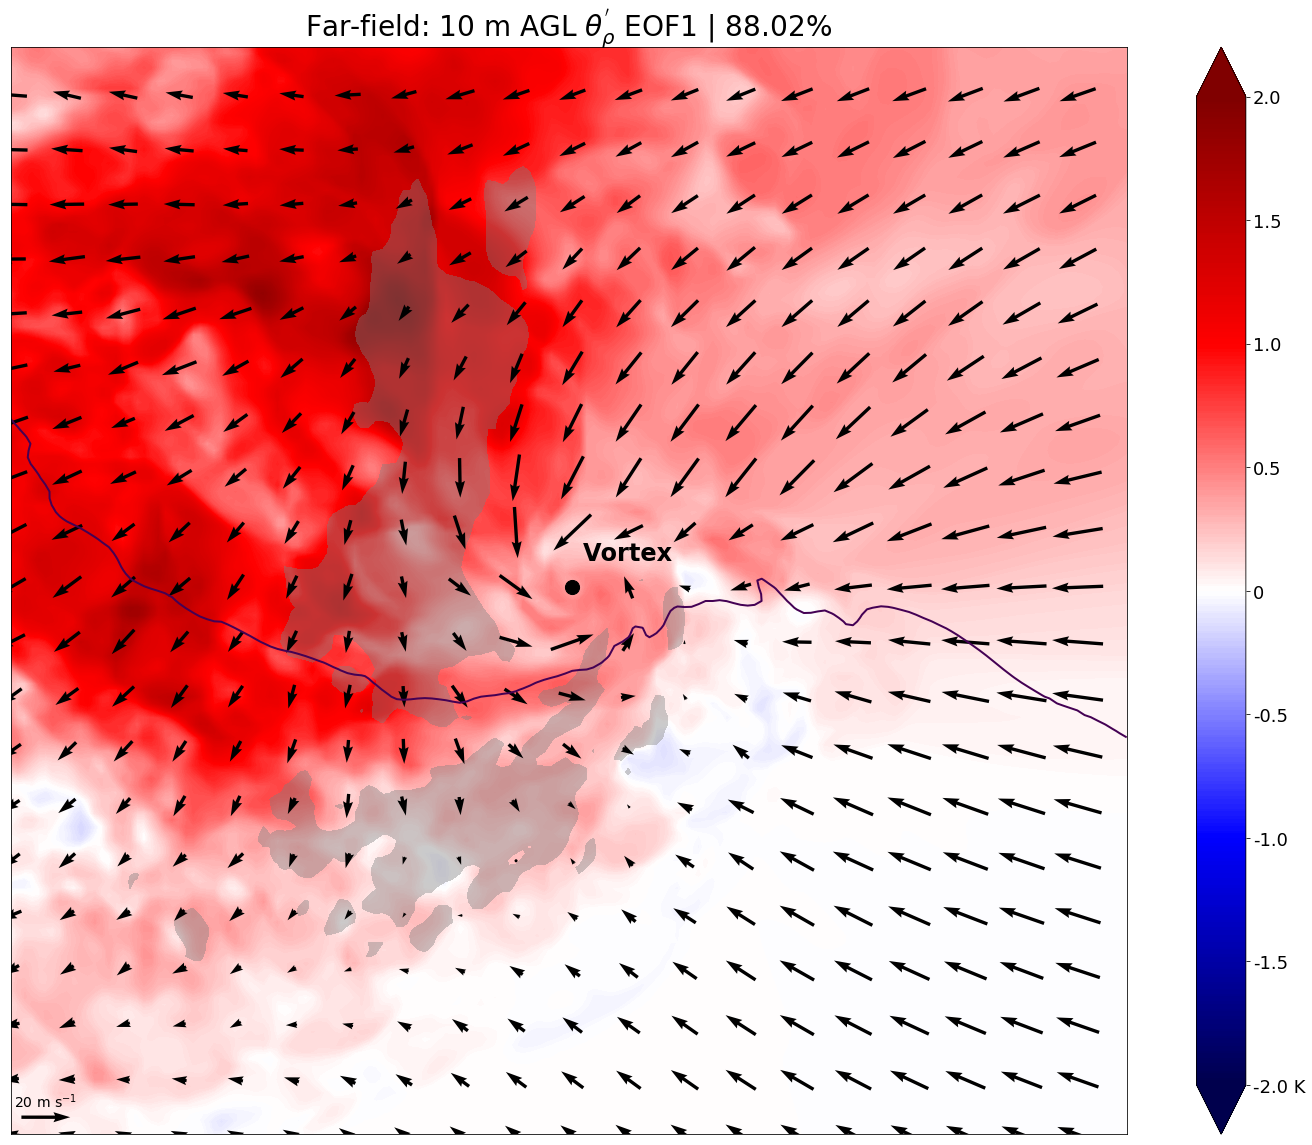

In [52]:
#====================================================================
# Now plot!
#====================================================================
%matplotlib inline
plt.rcParams['figure.figsize'] = [25,20]

x = np.arange(0,EOFs.shape[1])
y = np.arange(0,EOFs.shape[2])

# --- Which mode do we want to plot? ---
mode = 0

cmap1 = plt.cm.get_cmap('seismic')
new_cmap = cmap1

# --- Composite 10 dBZ 10 m AGL reflectivity ---
refl = plt.contour(x,y,refl_ff_comp,'k',linewidths=2,levels=[10])
# h1,_ = refl.legend_elements()

# --- Composite 20 m/s 1 km AGL updraft ---
# w = plt.contour(x,y,w_ff_comp,'k',linestyles='dashed',linewidths=4,levels=[15],label='Composite Updraft')
# h2,_ = w.legend_elements()

# --- EOF thetarho (shaded) ---
levels = np.arange(-2.0,2.01,0.01)
plt.contourf(x,y,EOFs[mode,:,:],cmap=new_cmap,levels=levels,extend='both')

plt.xticks([],[])
plt.yticks([],[])

ticks=np.arange(-2.0,2.5,0.5)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticklabels(['-2.0 K','-1.5','-1.0','-0.5','0','0.5','1.0','1.5','2.0'])

# --- EOF uv direction (contoured) ---
levels = [-100,-20]
plt.contourf(x,y,EOFs_uvdir[mode,:,:],'k',levels=levels,cmap=plt.cm.get_cmap('binary'),alpha=0.4,linewidths=4)

#------------------------------------------------------
# Plot vortex location.
#------------------------------------------------------
plt.scatter(dist,dist,s=200,c='black')
plt.text(dist+8,dist+4,'Vortex',color='black',fontsize=24,fontweight='bold',alpha=1.0,\
         horizontalalignment='center')

#------------------------------------------------------
# Plot storm-relative 10 m AGL winds.
#------------------------------------------------------
inc = 8
    
x_arrows, y_arrows = np.meshgrid(np.arange(0,EOFs.shape[2],inc),np.arange(0,EOFs.shape[1],inc))
    
arrows = plt.quiver(x_arrows,y_arrows,u_sr_ff_comp[::inc,::inc],\
                    v_sr_ff_comp[::inc,::inc],\
                    pivot='mid')
    
# ----- creating the reference vector -----
plt.quiverkey(arrows,5,2.5,20,'20 m s$^{-1}$',coordinates='data',facecolor='black',\
             fontproperties={'size': 14})
    
# key_text_x = 536
# key_text_y = 335
# key_text   = '10 m AGL'
# plt.text(key_text_x,key_text_y,\
#              key_text,\
#              fontsize=10,\
#              color='black',\
#              ha='center',\
#              va='center')

#------------------------------------------------------
# Other stuff.
#------------------------------------------------------
title = r"Far-field: 10 m AGL $\theta_{\rho}^{'}$ EOF" + str(mode+1) + ' | ' + str(np.round(varExp[mode],2)) + '%'
plt.title(title,fontsize=28,y=1.005)

# plt.legend([h1[0], h2[0]], ['Composite Reflectivity', 'Composite Updraft'],fontsize=18,shadow=False,\
#            loc='lower left',fancybox=True,framealpha=0.5)

plt.savefig(r'/Users/matt.flournoy/Desktop/stuff/PhD_Research/CM1/plots/far_and_near_field_ensembles_rerun/ff_thetarho_uvdir_EOF'+str(mode+1),dpi=300)








